<a href="https://colab.research.google.com/github/woncoh1/era1a10/blob/main/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
- Data
    - Dataset: CIFAR-10
    - Data augmentation: Albumentations
- Model
    - Model architecture: ResNet
    - Loss function: Cross entropy
- Optimization
    - Optimization algorithm: Adam
    - LR scheduler: One-cycle policy

## Targets
- Test accuracy > 90.0 %
- Number of parameters: unlimited
- Number of epochs: 24

## Results
- Best train accuracy = 97.81 %
- Best test accuracy = 93.08 %
- Number of parameters = 6,573,120
- Number of epochs = 24

In [1]:
!git clone https://github.com/woncoh1/era1a10.git

Cloning into 'era1a10'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 112 (delta 57), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (112/112), 507.49 KiB | 6.51 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
%pip install torchinfo -Uqq
%pip install albumentations -Uqq
%pip install torch-lr-finder -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 2.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchinfo import summary
from torch_lr_finder import LRFinder

from era1a10.src import data, engine, models, utils

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Device

## Colab runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch device
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data

In [5]:
params_dataloader = {
    'batch_size': 512,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [6]:
transform = data.get_transform()
dataset = data.get_dataset(transform)
loader = data.get_dataloader(dataset, params_dataloader)

100%|██████████| 170498071/170498071 [00:01<00:00, 101503883.28it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


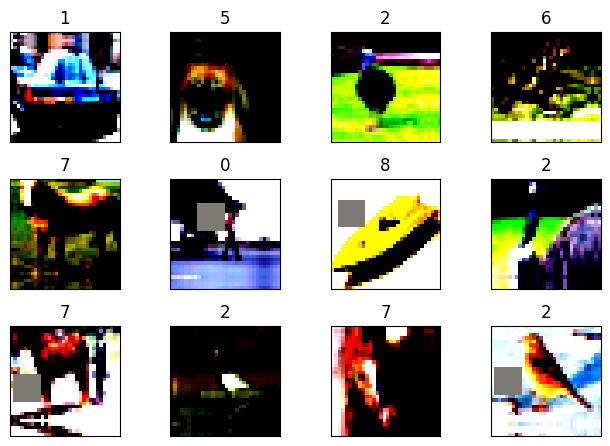

In [7]:
utils.plot_batch_samples(loader['train'])

# Model

In [8]:
criterion = nn.CrossEntropyLoss()
model = models.PageNet().to(device)

summary(
    model,
    input_size=(params_dataloader['batch_size'], *data.CHW),
    row_settings=['var_names'],
)

Layer (type (var_name))                  Output Shape              Param #
PageNet (PageNet)                        [512, 10]                 --
├─Sequential (conv0)                     [512, 64, 32, 32]         --
│    └─Conv2d (0)                        [512, 64, 32, 32]         1,728
│    └─BatchNorm2d (1)                   [512, 64, 32, 32]         128
│    └─Dropout (2)                       [512, 64, 32, 32]         --
│    └─ReLU (3)                          [512, 64, 32, 32]         --
├─SkipBlock (conv1)                      [512, 128, 16, 16]        --
│    └─Sequential (conv)                 [512, 128, 16, 16]        --
│    │    └─Conv2d (0)                   [512, 128, 32, 32]        73,728
│    │    └─MaxPool2d (1)                [512, 128, 16, 16]        --
│    │    └─BatchNorm2d (2)              [512, 128, 16, 16]        256
│    │    └─Dropout (3)                  [512, 128, 16, 16]        --
│    │    └─ReLU (4)                     [512, 128, 16, 16]        --
│    └

# Training

## Find max LR

In [9]:
params_optimizer = {
    'lr': 1E-3, # 1E-7 -> 1E-3
}
params_lr_finder = {
    'end_lr': 1, # 10 -> 1
    'num_iter': 200, # 10 -> 200
    'step_mode': 'exp',
}

In [10]:
optimizer = optim.Adam(model.parameters(), **params_optimizer)

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.52E-03


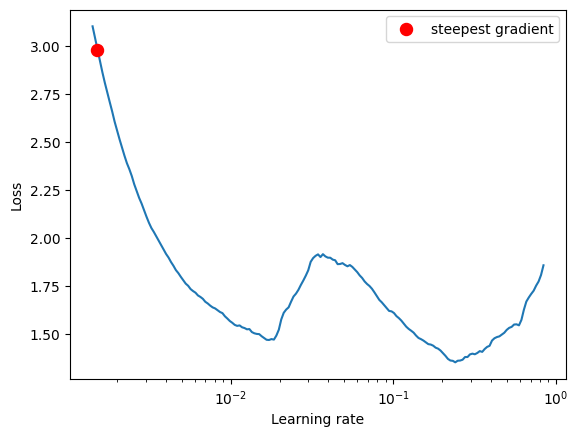

In [11]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(loader['train'], **params_lr_finder)
lr_finder.plot() # Inspect the loss-learning rate graph
lr_finder.reset() # Reset the model and optimizer to their initial states

## Update weights

In [12]:
params_trainer = {
    'num_epochs': 24,
}
params_scheduler = {
    'max_lr': 4E-3, # From lr_finder
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
    'pct_start': 0.2, # 20 % warm-up phase
    'anneal_strategy': 'linear', # Linear cool-down phase
    'three_phase': False, # No annihilation phase
    'div_factor': 100, # Initial LR: start from 1 % of max_lr
}

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00304, Accuracy = 45.46%, Epoch = 1
Test : Loss = 0.00248, Accuracy = 56.61%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00189, Accuracy = 65.79%, Epoch = 2
Test : Loss = 0.00179, Accuracy = 69.52%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00147, Accuracy = 73.73%, Epoch = 3
Test : Loss = 0.00150, Accuracy = 74.20%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00124, Accuracy = 78.04%, Epoch = 4
Test : Loss = 0.00171, Accuracy = 70.91%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00114, Accuracy = 79.78%, Epoch = 5
Test : Loss = 0.00140, Accuracy = 78.20%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00096, Accuracy = 83.00%, Epoch = 6
Test : Loss = 0.00103, Accuracy = 82.67%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00082, Accuracy = 85.63%, Epoch = 7
Test : Loss = 0.00094, Accuracy = 84.46%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00071, Accuracy = 87.50%, Epoch = 8
Test : Loss = 0.00084, Accuracy = 86.08%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00066, Accuracy = 88.20%, Epoch = 9
Test : Loss = 0.00082, Accuracy = 86.58%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00059, Accuracy = 89.38%, Epoch = 10
Test : Loss = 0.00085, Accuracy = 86.12%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00053, Accuracy = 90.48%, Epoch = 11
Test : Loss = 0.00065, Accuracy = 89.18%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00048, Accuracy = 91.47%, Epoch = 12
Test : Loss = 0.00068, Accuracy = 88.69%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00043, Accuracy = 92.36%, Epoch = 13
Test : Loss = 0.00060, Accuracy = 90.00%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00039, Accuracy = 93.12%, Epoch = 14
Test : Loss = 0.00060, Accuracy = 90.28%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00037, Accuracy = 93.39%, Epoch = 15
Test : Loss = 0.00056, Accuracy = 91.01%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00033, Accuracy = 94.15%, Epoch = 16
Test : Loss = 0.00056, Accuracy = 90.92%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00028, Accuracy = 94.90%, Epoch = 17
Test : Loss = 0.00055, Accuracy = 91.16%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00026, Accuracy = 95.42%, Epoch = 18
Test : Loss = 0.00051, Accuracy = 91.91%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00023, Accuracy = 96.03%, Epoch = 19
Test : Loss = 0.00054, Accuracy = 91.40%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00020, Accuracy = 96.39%, Epoch = 20
Test : Loss = 0.00049, Accuracy = 92.24%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00018, Accuracy = 96.85%, Epoch = 21
Test : Loss = 0.00049, Accuracy = 92.30%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00016, Accuracy = 97.29%, Epoch = 22
Test : Loss = 0.00047, Accuracy = 92.83%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00014, Accuracy = 97.64%, Epoch = 23
Test : Loss = 0.00045, Accuracy = 93.13%



  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss = 0.00012, Accuracy = 97.97%, Epoch = 24
Test : Loss = 0.00044, Accuracy = 93.26%



# Evaluation

## Learning curves

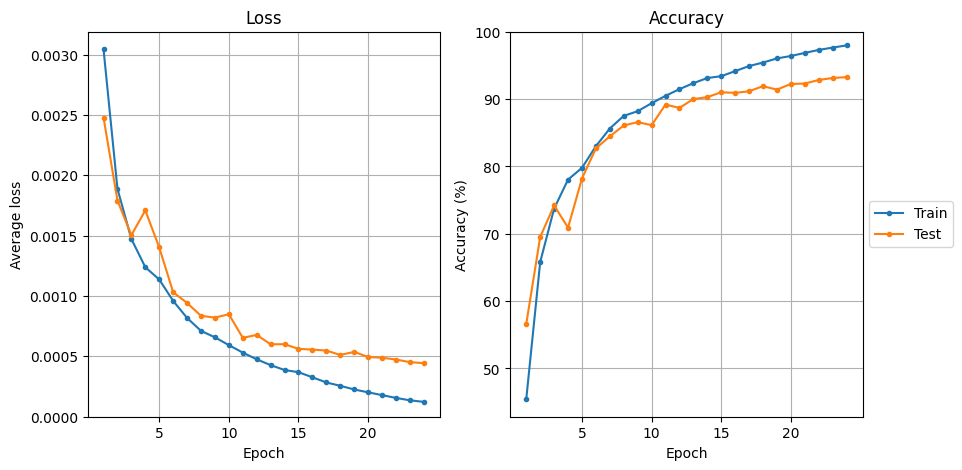

In [13]:
utils.plot_learning_curves(results, params_trainer['num_epochs'])

## Incorrect predictions

In [14]:
incorrects = utils.get_incorrect_predictions(
    device,
    data.get_dataloader(dataset, params_dataloader)['test'],
    model,
    criterion
)

Total Incorrect Predictions 674


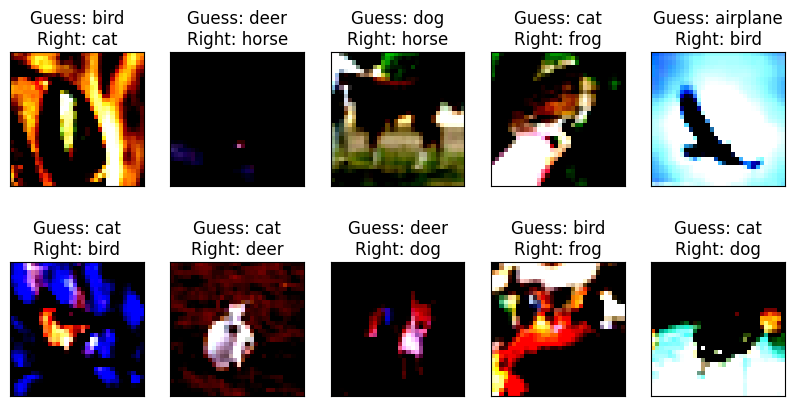

In [15]:
utils.plot_incorrect_predictions(incorrects, data.CLASSES)